# Evalution of scenario for Energy Consuptiom with Dynamic Bayesian Networks

Creation data: 18/03/2024 \
Last modiction: 18/03/2024 \
By: Victor Girou

## Import

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller 

from pgmpy.models import DynamicBayesianNetwork as DBN
from pgmpy.inference import DBNInference

from models.model_v0 import DumbDiscretizer, pgmpy_friendly_transformer, CustomDBNInference



c:\Users\victo\anaconda3\envs\TimeSeries\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Problem modelization

## Data Preprocessing

In [2]:
df = pd.read_csv("WorldEnergyConsumption.csv", sep=',')
df.head()

,country,year,iso_code,population,gdp,biofuel_cons_change_pct,biofuel_cons_change_twh,biofuel_cons_per_capita,biofuel_consumption,biofuel_elec_per_capita,...,solar_share_elec,solar_share_energy,wind_cons_change_pct,wind_cons_change_twh,wind_consumption,wind_elec_per_capita,wind_electricity,wind_energy_per_capita,wind_share_elec,wind_share_energy
0,ASEAN (Ember),2000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN
1,ASEAN (Ember),2001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN
2,ASEAN (Ember),2002,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN
3,ASEAN (Ember),2003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN
4,ASEAN (Ember),2004,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN


In [3]:
df = df.loc[df['year'] > 1970]

In [4]:
df_usa = df[df['country']=='United States'][['year', 'gdp', 'population', 'energy_per_capita']]
df_usa.head()

,year,gdp,population,energy_per_capita
20659,1971,5.065682e+12,202907920.0,91613.023
20660,1972,5.334297e+12,205238384.0,95080.078
20661,1973,5.637203e+12,207314768.0,98110.688
20662,1974,5.621366e+12,209277968.0,94814.602
20663,1975,5.605795e+12,211274544.0,91442.539


In [63]:
df_usa['gdp_order_1'] = df_usa['gdp'] - df_usa['gdp'].shift()
df_usa['gdp_order_2'] = df_usa['gdp_order_1'] - df_usa['gdp_order_1'].shift()
df_usa['gdp_stationary'] = df_usa['gdp_order_2'] - df_usa['gdp_order_2'].shift()


df_usa['energy_per_capita_order_1'] = df_usa['energy_per_capita'] - df_usa['energy_per_capita'].shift()
df_usa['energy_per_capita_order_2'] = df_usa['energy_per_capita_order_1'] - df_usa['energy_per_capita_order_1'].shift()
df_usa['energy_per_capita_stationary'] = df_usa['energy_per_capita_order_2'] - df_usa['energy_per_capita_order_2'].shift()


df_usa['population_order_1'] = df_usa['population'] - df_usa['population'].shift()
df_usa['population_order_2'] = df_usa['population_order_1'] - df_usa['population_order_1'].shift()
df_usa['population_stationary'] = df_usa['population_order_2'] - df_usa['population_order_2'].shift()

#### Test stationarity

In [11]:
print(adfuller(df_usa['gdp_stationary'][3:-4]))
print(adfuller(df_usa['population_stationary'][3:]))
print(adfuller(df_usa['energy_per_capita_stationary'][3:]))

SyntaxError: invalid syntax. Perhaps you forgot a comma? (61762855.py, line 1)

Text(0.5, 1.0, 'Energy per Capita')

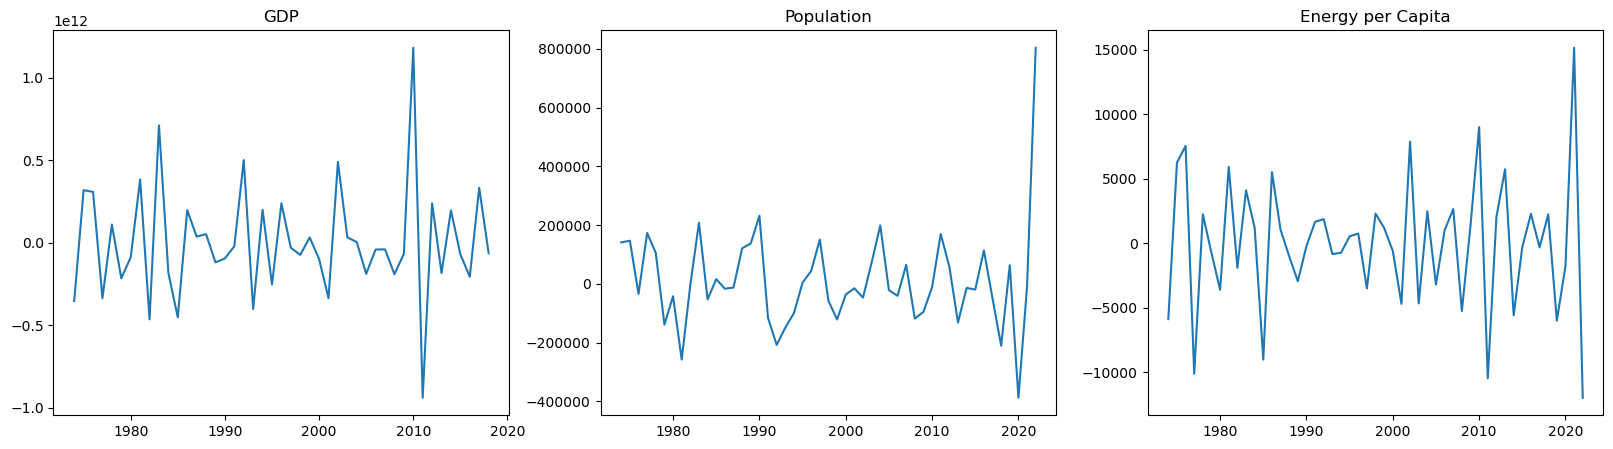

In [69]:
figs, axs = plt.subplots(1, 3, figsize=(20, 5))

axs[0].plot(df_usa['year'], df_usa['gdp_stationary'])
axs[0].set_title('GDP')
axs[1].plot(df_usa['year'], df_usa['population_stationary'])
axs[1].set_title('Population')
axs[2].plot(df_usa['year'], df_usa['energy_per_capita_stationary'])
axs[2].set_title('Energy per Capita')

In [72]:
print(len(df_usa['gdp_stationary'][3:-4]))
print(len(df_usa['population_stationary'][3:]))
print(len(df_usa['energy_per_capita_stationary'][3:]))

45
49
49


In [79]:
df_train = df_usa[['year', 'gdp_stationary', 'population_stationary', 'energy_per_capita_stationary']]

In [80]:
df_train = df_train.loc[(df_train['year'] >= 1974) & (df_train['year'] <= 2018)]

In [81]:
df_train

,year,gdp_stationary,population_stationary,energy_per_capita_stationary
20662,1974,-3.530351e+11,140896.0,-5890.251
20663,1975,3.190098e+11,146560.0,6250.719
20664,1976,3.091003e+11,-34464.0,7548.728
20665,1977,-3.358411e+11,172976.0,-10124.939
20666,1978,1.108649e+11,104768.0,2243.672
20667,1979,-2.145544e+11,-139024.0,-758.359
20668,1980,-8.834777e+10,-42384.0,-3611.343
20669,1981,3.841327e+11,-258176.0,5926.858
20670,1982,-4.639367e+11,-3632.0,-1907.265
20671,1983,7.120041e+11,207680.0,4101.852


## Transforming dataset

We need to make our dataset PGMpy friendly. For this we will used a custom class called DumbDiscretizer. 

In [83]:
nb_classes = {  # nb of classes for each variable
    "gdp_stationary": 3,  
    "population_stationary": 3, 
    "energy_per_capita_stationary": 3
}

# use dumb discretizer method. 
discretizer = DumbDiscretizer(df_train[['gdp_stationary', 'population_stationary', 'energy_per_capita_stationary']], nb_classes=nb_classes)

# save a discretized version of the dataframe
my_data_index = discretizer.df

In [84]:
my_data_index

,gdp_stationary,population_stationary,energy_per_capita_stationary
20662,1,2,1
20663,2,2,2
20664,2,1,3
20665,1,3,0
20666,2,2,2
20667,1,1,1
20668,1,1,1
20669,2,0,2
20670,1,1,1
20671,3,3,2


In [85]:
my_data_index_pgmpy = pgmpy_friendly_transformer(my_data_index, sliding_window=2)

In [86]:
my_data_index.columns

Index(['gdp_stationary', 'population_stationary',
       'energy_per_capita_stationary'],
      dtype='object')

## DBN Construction

In [87]:
dbn = DBN(
    [
        (("gdp_stationary", 0), ("energy_per_capita_stationary", 0)),
        (("population_stationary", 0), ("energy_per_capita_stationary", 0)),
        (('gdp_stationary', 0), ("gdp_stationary", 1)),
        (('population_stationary', 0), ("population_stationary", 1)),
    ]
)

In [88]:
dbn.fit(my_data_index_pgmpy)

In [89]:
my_data_index_pgmpy.nunique()

(gdp_stationary, 0)                  4
(population_stationary, 0)           4
(energy_per_capita_stationary, 0)    4
(gdp_stationary, 1)                  4
(population_stationary, 1)           4
(energy_per_capita_stationary, 1)    4
dtype: int64

## Forecasting with DBN

In [90]:
my_data = df_train[['gdp_stationary', 'population_stationary', 'energy_per_capita_stationary']].reset_index()

In [91]:
len(my_data)

45

In [92]:
nb_points = 45  # nb of time steps in the simulation 
length = 10  # forecast horizon
evidence_date = nb_points - length  # start of test set. 

In [101]:
# use custom inference for model test
inference = CustomDBNInference(dbn, discretizer)

# provide evidence
evidence_date = nb_points - length
evidence = {
    ("gdp_stationary", 0): my_data.loc[evidence_date, "gdp_stationary"], 
    ("population_stationary", 0): my_data.loc[evidence_date, "population_stationary"], 
}

print("Evidence: ", evidence, "\n")

# now make a pred of Y at time t (now) till time t+14
pred_seq = inference.make_pred("energy_per_capita_stationary",
                               forecast_step=length, 
                               evidence=evidence, 
                               method="PM", 
                               verbose=False)

# get actual values model should have predicted 
actual_seq =  my_data.loc[evidence_date:, "energy_per_capita_stationary"].to_list()

print("Actual seq: ", actual_seq)
print("Pred seq: ", pred_seq)

Evidence:  {('gdp_stationary', 0): -67389882368.0, ('population_stationary', 0): -95616.0} 

Actual seq:  [1358.6199999999953, 9009.74000000002, -10480.180000000022, 2031.518000000011, 5739.084000000003, -5599.789000000019, -290.68699999997625, 2280.179999999993, -324.5940000000119, 2239.570000000007]
Pred seq:  [-649.6640000000011, 943.1794933837454, 315.1003269866346, 601.2124132780912, 601.2124132780912, 601.2124132780912, 601.2124132780912, 601.2124132780912, 601.2124132780912, 601.2124132780912]


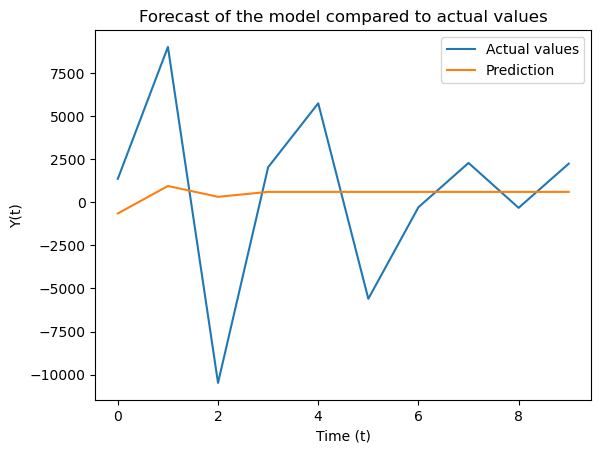

In [99]:
# get sequences
whole_seq = my_data.loc[evidence_date:, "energy_per_capita_stationary"]
all_pred_seq = np.array(pred_seq) 

# plot sequence on a same plot 
plt.plot(np.arange(length), whole_seq, label="Actual values")
plt.plot(np.arange(length), all_pred_seq, label="Prediction")

plt.title("Forecast of the model compared to actual values")
plt.xlabel("Time (t)")
plt.ylabel("Y(t)")
plt.legend()
plt.show()

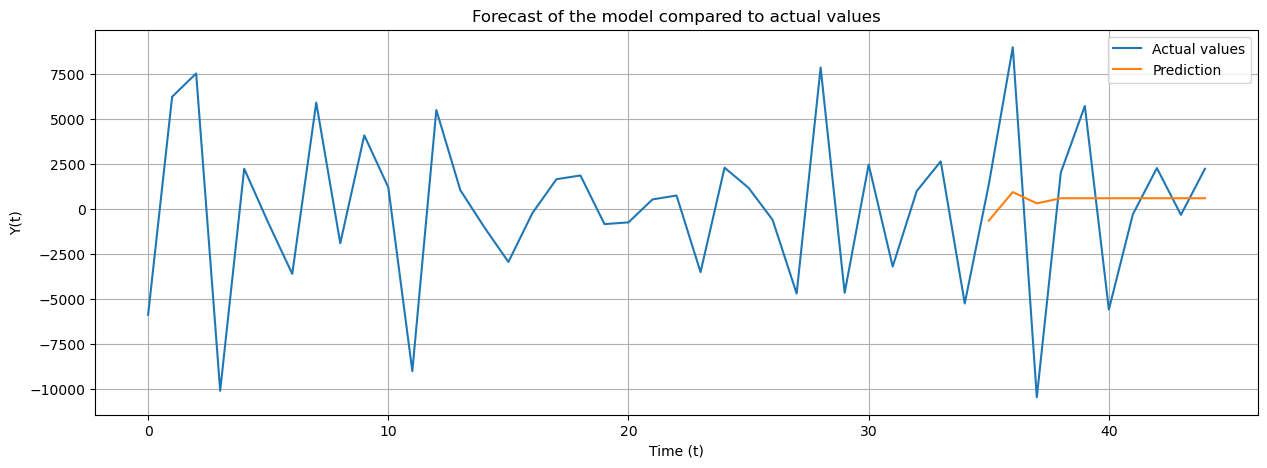

In [113]:
# get sequences
whole_seq = my_data["energy_per_capita_stationary"]
all_pred_seq = np.array(pred_seq)


figs, axs = plt.subplots(1, 1, figsize=(15, 5))

# plot sequence on a same plot 
axs.plot(whole_seq, label="Actual values")
axs.plot(np.arange(evidence_date, evidence_date + length), all_pred_seq, label="Prediction")

axs.set_title("Forecast of the model compared to actual values")
axs.set_xlabel("Time (t)")
axs.set_ylabel("Y(t)")
axs.legend()
axs.grid()


In [111]:
pred_seq

[-649.6640000000011,
 943.1794933837454,
 315.1003269866346,
 601.2124132780912,
 601.2124132780912,
 601.2124132780912,
 601.2124132780912,
 601.2124132780912,
 601.2124132780912,
 601.2124132780912]

In [114]:
df_pred = df_usa.loc[(df_usa['year'] >= 1974) & (df_usa['year'] <= 2018)].reset_index()

Essayons maintenant de reconstruire le signal d'origine. L'pération shift que nous avons utilisé pour stationariser nos données revient à calculer l'accroisssement sur l'année. Pour retrouver le signal d'origine il nous suffit de nous référer à la dernière valeur connue.

In [116]:
last_value_enregie = df_usa["energy_per_capita"].iloc[evidence_date-1]

In [117]:
last_value_enregie

90654.531

In [118]:
energy_pred = np.zeros(length)
energy_pred[0] = last_value_enregie + pred_seq[0]

for i in range(1, length):

    energy_pred[i] = energy_pred[i-1] + pred_seq[i]

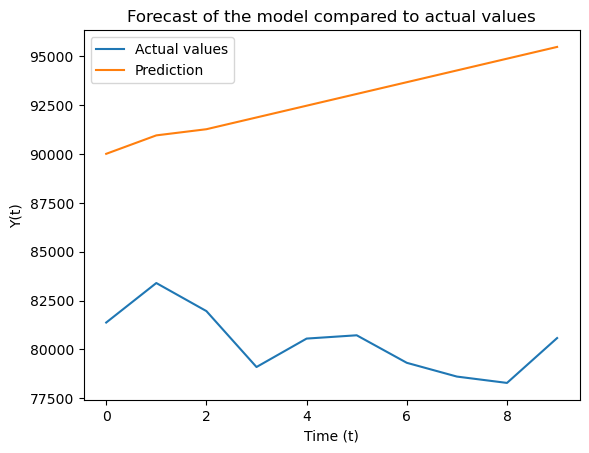

In [119]:
# get sequences
whole_seq = df_pred.loc[evidence_date:, "energy_per_capita"]

# plot sequence on a same plot 
plt.plot(np.arange(length), whole_seq, label="Actual values")
plt.plot(np.arange(length), energy_pred, label="Prediction")

plt.title("Forecast of the model compared to actual values")
plt.xlabel("Time (t)")
plt.ylabel("Y(t)")
plt.legend()
plt.show()

Globalement, le modèle retourne la valeur moyenne lorsque la fenêtre est importante

## Deuxième approche 

Nous allons essayer une nouvelle approche. Dans un premier temps nous allons considérer tous les pays. Dans un second temps nous allons investiguer une autre manière d'obtenir un signal stationnaire, à savoir d'abord appliquer le logarithme aux signaux avant de les différencier. 

In [102]:
df_usa = df[df['country']=='United States'][['year', 'gdp', 'population', 'energy_per_capita']]
df_usa.head()

,year,gdp,population,energy_per_capita
20659,1971,5.065682e+12,202907920.0,91613.023
20660,1972,5.334297e+12,205238384.0,95080.078
20661,1973,5.637203e+12,207314768.0,98110.688
20662,1974,5.621366e+12,209277968.0,94814.602
20663,1975,5.605795e+12,211274544.0,91442.539


In [103]:
df_france = df[df['country']=='France'][['year', 'gdp', 'population', 'energy_per_capita']]
df_france.head()

,year,gdp,population,energy_per_capita
7303,1971,9.899686e+11,50970696.0,36781.766
7304,1972,1.034025e+12,51410364.0,38982.227
7305,1973,1.090180e+12,51814076.0,41995.258
7306,1974,1.122228e+12,52163552.0,40967.301
7307,1975,1.114333e+12,52450032.0,38383.664


In [104]:
df_japan = df[df['country']=='Japan'][['year', 'gdp', 'population', 'energy_per_capita']]
df_japan.head()

,year,gdp,population,energy_per_capita
10140,1971,1.691571e+12,106789360.0,32622.004
10141,1972,1.833991e+12,108220400.0,33721.758
10142,1973,1.981290e+12,109679472.0,36916.078
10143,1974,1.957033e+12,111100024.0,36618.078
10144,1975,2.017465e+12,112411640.0,34575.215


In [105]:
df_germany = df[df['country']=='Germany'][['year', 'gdp', 'population', 'energy_per_capita']]
df_germany.head()

,year,gdp,population,energy_per_capita
7752,1971,1.383509e+12,78511408.0,46407.992
7753,1972,1.440601e+12,78643560.0,47940.641
7754,1973,1.505896e+12,78667472.0,50686.184
7755,1974,1.518361e+12,78620536.0,49834.656
7756,1975,1.510150e+12,78513512.0,47948.027


In [106]:
df_usa['gdp_order_1'] = df_usa['gdp'] - df_usa['gdp'].shift()
df_usa['gdp_order_2'] = df_usa['gdp_order_1'] - df_usa['gdp_order_1'].shift()
df_usa['gdp_stationary'] = df_usa['gdp_order_2'] - df_usa['gdp_order_2'].shift()


df_usa['energy_per_capita_order_1'] = df_usa['energy_per_capita'] - df_usa['energy_per_capita'].shift()
df_usa['energy_per_capita_order_2'] = df_usa['energy_per_capita_order_1'] - df_usa['energy_per_capita_order_1'].shift()
df_usa['energy_per_capita_stationary'] = df_usa['energy_per_capita_order_2'] - df_usa['energy_per_capita_order_2'].shift()


df_usa['population_order_1'] = df_usa['population'] - df_usa['population'].shift()
df_usa['population_order_2'] = df_usa['population_order_1'] - df_usa['population_order_1'].shift()
df_usa['population_stationary'] = df_usa['population_order_2'] - df_usa['population_order_2'].shift()

df_france['gdp_order_1'] = df_france['gdp'] - df_france['gdp'].shift()
df_france['gdp_order_2'] = df_france['gdp_order_1'] - df_france['gdp_order_1'].shift()
df_france['gdp_stationary'] = df_france['gdp_order_2'] - df_france['gdp_order_2'].shift()


df_france['energy_per_capita_order_1'] = df_france['energy_per_capita'] - df_france['energy_per_capita'].shift()
df_france['energy_per_capita_order_2'] = df_france['energy_per_capita_order_1'] - df_france['energy_per_capita_order_1'].shift()
df_france['energy_per_capita_stationary'] = df_france['energy_per_capita_order_2'] - df_france['energy_per_capita_order_2'].shift()


df_france['population_order_1'] = df_france['population'] - df_france['population'].shift()
df_france['population_order_2'] = df_france['population_order_1'] - df_france['population_order_1'].shift()
df_france['population_stationary'] = df_france['population_order_2'] - df_france['population_order_2'].shift()

df_germany['gdp_order_1'] = df_germany['gdp'] - df_germany['gdp'].shift()
df_germany['gdp_order_2'] = df_germany['gdp_order_1'] - df_germany['gdp_order_1'].shift()
df_germany['gdp_stationary'] = df_germany['gdp_order_2'] - df_germany['gdp_order_2'].shift()


df_germany['energy_per_capita_order_1'] = df_germany['energy_per_capita'] - df_germany['energy_per_capita'].shift()
df_germany['energy_per_capita_order_2'] = df_germany['energy_per_capita_order_1'] - df_germany['energy_per_capita_order_1'].shift()
df_germany['energy_per_capita_stationary'] = df_germany['energy_per_capita_order_2'] - df_germany['energy_per_capita_order_2'].shift()


df_germany['population_order_1'] = df_germany['population'] - df_germany['population'].shift()
df_germany['population_order_2'] = df_germany['population_order_1'] - df_germany['population_order_1'].shift()
df_germany['population_stationary'] = df_germany['population_order_2'] - df_germany['population_order_2'].shift()

In [107]:
print(adfuller(df_usa['gdp_stationary'][3:-4]))
print(adfuller(df_usa['population_stationary'][3:]))
print(adfuller(df_usa['energy_per_capita_stationary'][3:]))

(-3.98770907846902, 0.0014762553555365263, 9, 35, {'1%': -3.6327426647230316, '5%': -2.9485102040816327, '10%': -2.6130173469387756}, 1880.3138638436671)
(-3.5071505242663634, 0.007805341279116967, 7, 41, {'1%': -3.60098336718852, '5%': -2.9351348158036012, '10%': -2.6059629803688282}, 987.9357999939783)
(-5.503316067188156, 2.048051592481238e-06, 10, 38, {'1%': -3.6155091011809297, '5%': -2.941262357486514, '10%': -2.6091995013850418}, 674.6949317286684)


In [108]:
print(adfuller(df_france['gdp_stationary'][3:-4]))
print(adfuller(df_france['population_stationary'][3:]))
print(adfuller(df_france['energy_per_capita_stationary'][3:]))

(-5.598662809523582, 1.2796352549197956e-06, 5, 39, {'1%': -3.610399601308181, '5%': -2.939108945868946, '10%': -2.6080629651545038}, 1751.7948371004682)
(-6.079496508526538, 1.1009118602952568e-07, 1, 47, {'1%': -3.5778480370438146, '5%': -2.925338105429433, '10%': -2.6007735310095064}, 827.395526766903)
(-7.441275892050861, 5.996810573289528e-11, 7, 41, {'1%': -3.60098336718852, '5%': -2.9351348158036012, '10%': -2.6059629803688282}, 646.5233151784307)


In [109]:
print(adfuller(df_germany['gdp_stationary'][3:-4]))
print(adfuller(df_germany['population_stationary'][3:]))
print(adfuller(df_germany['energy_per_capita_stationary'][3:]))

(-4.901998700247192, 3.45632945614418e-05, 8, 36, {'1%': -3.626651907578875, '5%': -2.9459512825788754, '10%': -2.6116707716049383}, 1801.8841848716131)
(-4.835640025612742, 4.646151649262576e-05, 0, 48, {'1%': -3.5745892596209488, '5%': -2.9239543084490744, '10%': -2.6000391840277777}, 845.8896861829007)
(-4.811584382846462, 5.167771732070864e-05, 11, 37, {'1%': -3.6209175221605827, '5%': -2.9435394610388332, '10%': -2.6104002410518627}, 650.2540196942207)


In [110]:
df_train_usa = df_usa[['year', 'gdp_stationary', 'population_stationary', 'energy_per_capita_stationary']]
df_train_usa = df_train_usa.loc[(df_train_usa['year'] >= 1974) & (df_train_usa['year'] <= 2018)]

nb_classes = {  # nb of classes for each variable
    "gdp_stationary": 3,  
    "population_stationary": 3, 
    "energy_per_capita_stationary": 3
}

# use dumb discretizer method. 
discretizer = DumbDiscretizer(df_train_usa[['gdp_stationary', 'population_stationary', 'energy_per_capita_stationary']], nb_classes=nb_classes)

# save a discretized version of the dataframe
my_data_index_usa = discretizer.df

my_data_index_pgmpy_usa = pgmpy_friendly_transformer(my_data_index_usa, sliding_window=2)

In [111]:
df_train_france = df_france[['year', 'gdp_stationary', 'population_stationary', 'energy_per_capita_stationary']]
df_train_france = df_train_france.loc[(df_train_france['year'] >= 1974) & (df_train_france['year'] <= 2018)]

nb_classes = {  # nb of classes for each variable
    "gdp_stationary": 3,  
    "population_stationary": 3, 
    "energy_per_capita_stationary": 3
}

# use dumb discretizer method. 
discretizer = DumbDiscretizer(df_train_france[['gdp_stationary', 'population_stationary', 'energy_per_capita_stationary']], nb_classes=nb_classes)

# save a discretized version of the dataframe
my_data_index_france = discretizer.df

my_data_index_pgmpy_france = pgmpy_friendly_transformer(my_data_index_france, sliding_window=2)

In [112]:
df_train_germany = df_germany[['year', 'gdp_stationary', 'population_stationary', 'energy_per_capita_stationary']]
df_train_germany = df_train_germany.loc[(df_train_germany['year'] >= 1974) & (df_train_germany['year'] <= 2018)]

nb_classes = {  # nb of classes for each variable
    "gdp_stationary": 3,  
    "population_stationary": 3, 
    "energy_per_capita_stationary": 3
}

# use dumb discretizer method. 
discretizer = DumbDiscretizer(df_train_germany[['gdp_stationary', 'population_stationary', 'energy_per_capita_stationary']], nb_classes=nb_classes)

# save a discretized version of the dataframe
my_data_index_germany = discretizer.df

my_data_index_pgmpy_germany = pgmpy_friendly_transformer(my_data_index_germany, sliding_window=2)

In [113]:
my_data_index_pgmpy = pd.concat([my_data_index_pgmpy_usa, my_data_index_pgmpy_france, my_data_index_pgmpy_germany], ignore_index=True)

In [114]:
my_data_index_pgmpy

,"(gdp_stationary, 0)","(population_stationary, 0)","(energy_per_capita_stationary, 0)","(gdp_stationary, 1)","(population_stationary, 1)","(energy_per_capita_stationary, 1)"
0,1,2,1,2,2,2
1,2,2,2,2,1,3
2,2,1,3,1,3,0
3,1,3,0,2,2,2
4,2,2,2,1,1,1
...,...,...,...,...,...,...
121,0,2,0,1,1,3
122,1,1,3,2,1,1
123,2,1,1,2,2,1
124,2,2,1,1,1,3


In [115]:
dbn = DBN(
    [
        (("gdp_stationary", 0), ("energy_per_capita_stationary", 0)),
        (("population_stationary", 0), ("energy_per_capita_stationary", 0)),
        (('gdp_stationary', 0), ("gdp_stationary", 1)),
        (('population_stationary', 0), ("population_stationary", 1)),
    ]
)

dbn.fit(my_data_index_pgmpy)

In [116]:
my_data = df_train_germany[['gdp_stationary', 'population_stationary', 'energy_per_capita_stationary']].reset_index()

In [117]:
nb_points = 45  # nb of time steps in the simulation 
length = 5  # forecast horizon
evidence_date = nb_points - length  # start of test set. 

In [118]:
# use custom inference for model test
inference = CustomDBNInference(dbn, discretizer)

# provide evidence
evidence_date = nb_points - length
evidence = {
    ("gdp_stationary", 0): my_data.loc[evidence_date, "gdp_stationary"], 
    ("population_stationary", 0): my_data.loc[evidence_date, "population_stationary"], 
}

print("Evidence: ", evidence, "\n")

# now make a pred of Y at time t (now) till time t+14
pred_seq = inference.make_pred("energy_per_capita_stationary",
                               forecast_step=length, 
                               evidence=evidence, 
                               method="PM", 
                               verbose=False)

# get actual values model should have predicted 
actual_seq =  my_data.loc[evidence_date:, "energy_per_capita_stationary"].to_list()

print("Actual seq: ", actual_seq)
print("Pred seq: ", pred_seq)

Evidence:  {('gdp_stationary', 0): 39437991936.0, ('population_stationary', 0): 30368.0} 

Actual seq:  [-3930.5670000000027, 6036.1700000000055, -2903.74500000001, -41.333999999995285, -1596.8439999999973]
Pred seq:  [469.90974999999946, -524.9319098181809, 425.66667106624607, 297.6657856806074, 297.6657856806074]


c:\Users\victo\anaconda3\envs\TimeSeries\Lib\site-packages\pgmpy\factors\discrete\DiscreteFactor.py:796: RuntimeWarning: invalid value encountered in divide
  phi.values = phi.values / phi1.values


In [119]:
def stationarize(df: pd.DataFrame):

    df['log_gdp'] = df['gdp'].apply(lambda x: np.log(x))
    df['gdp_order_1'] = df['log_gdp'] - df['log_gdp'].shift()
    df['gdp_stationary'] = df['gdp_order_1'] - df['gdp_order_1'].shift()

    df['log_energy'] = df['energy_per_capita'].apply(lambda x: np.log(x))
    df['energy_per_capita_order_1'] = df['log_energy'] - df['log_energy'].shift()
    df['energy_per_capita_stationary'] = df['energy_per_capita_order_1'] - df['energy_per_capita_order_1'].shift()
    
    df['log_pop'] = df['population'].apply(lambda x: np.log(x))
    df['population_order_1'] = df['log_pop'] - df['log_pop'].shift()
    df['population_stationary'] = df['population_order_1'] - df['population_order_1'].shift()


In [120]:
stationarize(df_usa)

In [121]:
stationarize(df_france)
stationarize(df_germany)

In [122]:
df_train_usa = df_usa[['year', 'gdp_stationary', 'population_stationary', 'energy_per_capita_stationary']]
df_train_usa = df_train_usa.loc[(df_train_usa['year'] >= 1974) & (df_train_usa['year'] <= 2018)]

nb_classes = {  # nb of classes for each variable
    "gdp_stationary": 3,  
    "population_stationary": 3, 
    "energy_per_capita_stationary": 3
}

# use dumb discretizer method. 
discretizer = DumbDiscretizer(df_train_usa[['gdp_stationary', 'population_stationary', 'energy_per_capita_stationary']], nb_classes=nb_classes)

# save a discretized version of the dataframe
my_data_index_usa = discretizer.df

my_data_index_pgmpy_usa = pgmpy_friendly_transformer(my_data_index_usa, sliding_window=2)

In [ ]:
df_train_france = df_france[['year', 'gdp_stationary', 'population_stationary', 'energy_per_capita_stationary']]
df_train_france = df_train_france.loc[(df_train_france['year'] >= 1974) & (df_train_france['year'] <= 2018)]

nb_classes = {  # nb of classes for each variable
    "gdp_stationary": 3,  
    "population_stationary": 3, 
    "energy_per_capita_stationary": 3
}

# use dumb discretizer method. 
discretizer = DumbDiscretizer(df_train_france[['gdp_stationary', 'population_stationary', 'energy_per_capita_stationary']], nb_classes=nb_classes)

# save a discretized version of the dataframe
my_data_index_france = discretizer.df

my_data_index_pgmpy_france = pgmpy_friendly_transformer(my_data_index_france, sliding_window=2)

In [ ]:
df_train_germany = df_germany[['year', 'gdp_stationary', 'population_stationary', 'energy_per_capita_stationary']]
df_train_germany = df_train_germany.loc[(df_train_germany['year'] >= 1974) & (df_train_germany['year'] <= 2018)]

nb_classes = {  # nb of classes for each variable
    "gdp_stationary": 3,  
    "population_stationary": 3, 
    "energy_per_capita_stationary": 3
}

# use dumb discretizer method. 
discretizer = DumbDiscretizer(df_train_germany[['gdp_stationary', 'population_stationary', 'energy_per_capita_stationary']], nb_classes=nb_classes)

# save a discretized version of the dataframe
my_data_index_germany = discretizer.df

my_data_index_pgmpy_germany = pgmpy_friendly_transformer(my_data_index_germany, sliding_window=2)

In [128]:
my_data_index_pgmpy = pd.concat([my_data_index_pgmpy_usa, my_data_index_pgmpy_france, my_data_index_pgmpy_germany], ignore_index=True)

In [129]:
dbn = DBN(
    [
        (("gdp_stationary", 0), ("energy_per_capita_stationary", 0)),
        (("population_stationary", 0), ("energy_per_capita_stationary", 0)),
        (('gdp_stationary', 0), ("gdp_stationary", 1)),
        (('population_stationary', 0), ("population_stationary", 1)),
    ]
)

dbn.fit(my_data_index_pgmpy)

In [130]:
my_data = df_train_usa[['gdp_stationary', 'population_stationary', 'energy_per_capita_stationary']].reset_index()

nb_points = 45  # nb of time steps in the simulation 
length = 5  # forecast horizon
evidence_date = nb_points - length  # start of test set. 

In [131]:
# use custom inference for model test
inference = CustomDBNInference(dbn, discretizer)

# provide evidence
evidence_date = nb_points - length
evidence = {
    ("gdp_stationary", 0): my_data.loc[evidence_date, "gdp_stationary"], 
    ("population_stationary", 0): my_data.loc[evidence_date, "population_stationary"], 
}

print("Evidence: ", evidence, "\n")

# now make a pred of Y at time t (now) till time t+14
pred_seq = inference.make_pred("energy_per_capita_stationary",
                               forecast_step=length, 
                               evidence=evidence, 
                               method="PM", 
                               verbose=False)

# get actual values model should have predicted 
actual_seq =  my_data.loc[evidence_date:, "energy_per_capita_stationary"].to_list()

print("Actual seq: ", actual_seq)
print("Pred seq: ", pred_seq)

Evidence:  {('gdp_stationary', 0): 0.006770212289193722, ('population_stationary', 0): -0.00027473613218020887} 

Actual seq:  [-0.016126110712898267, -0.019682655326080933, 0.008679101606826833, 0.0047764454266321366, 0.03302149454261816]
Pred seq:  [0.0032187601162739846, -0.0015965816880946192, -0.0017637106619512871, -0.006469566013887899, -0.006469566013887899]


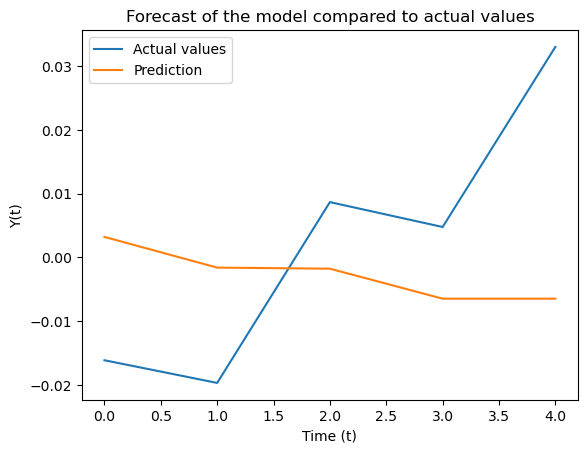

In [132]:
# get sequences
whole_seq = my_data.loc[evidence_date:, "energy_per_capita_stationary"]
all_pred_seq = np.array(pred_seq) 

# plot sequence on a same plot 
plt.plot(np.arange(length), whole_seq, label="Actual values")
plt.plot(np.arange(length), all_pred_seq, label="Prediction")

plt.title("Forecast of the model compared to actual values")
plt.xlabel("Time (t)")
plt.ylabel("Y(t)")
plt.legend()
plt.show()

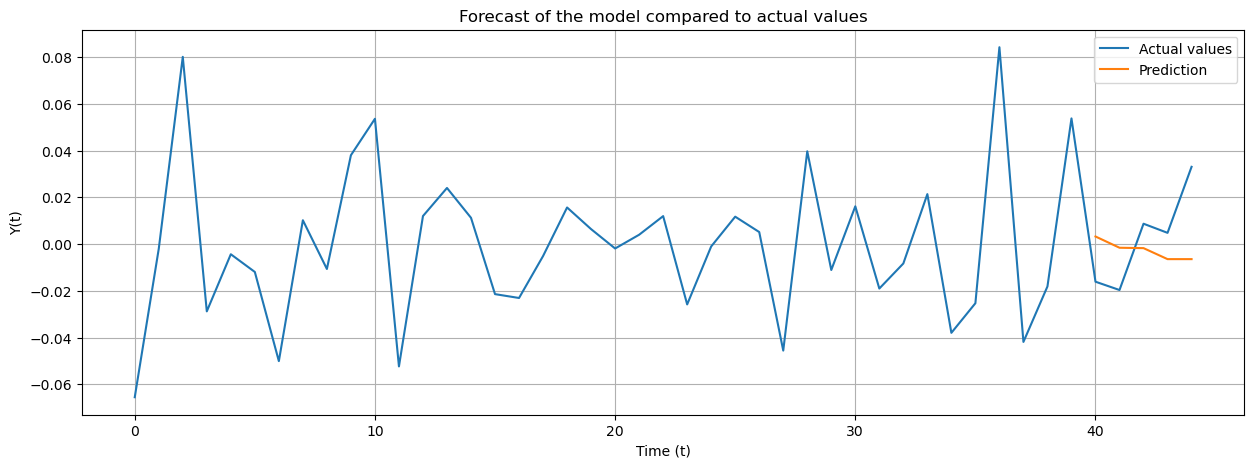

In [133]:
# get sequences
whole_seq = my_data["energy_per_capita_stationary"]
all_pred_seq = np.array(pred_seq)


figs, axs = plt.subplots(1, 1, figsize=(15, 5))

# plot sequence on a same plot 
axs.plot(whole_seq, label="Actual values")
axs.plot(np.arange(evidence_date, evidence_date + length), all_pred_seq, label="Prediction")

axs.set_title("Forecast of the model compared to actual values")
axs.set_xlabel("Time (t)")
axs.set_ylabel("Y(t)")
axs.legend()
axs.grid()
